In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


In [3]:
# importing in all the data
wnvd_train = pd.read_csv('../output/train_weather_daily.csv')
wnvd_test = pd.read_csv('../output/test_weather_daily.csv')

In [67]:
# Establishing our baseline accuracy

baseline_accuracy = wnvd_train['WnvPresent'].value_counts()[0]/len(wnvd_train['WnvPresent'])
baseline_accuracy

0.9475537787930707

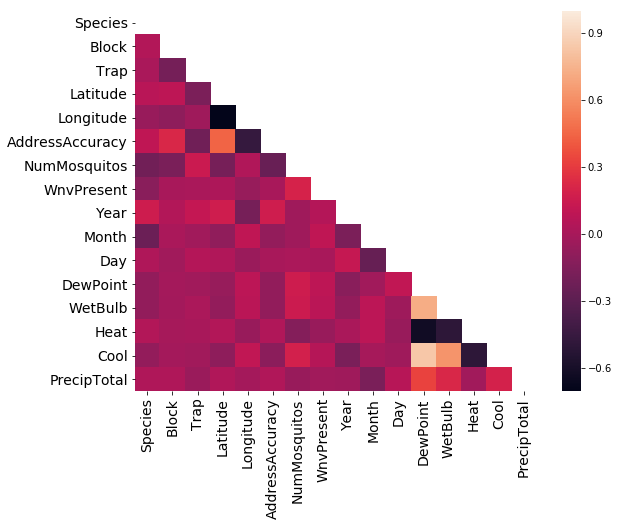

In [68]:
# correlation heatmap

mean_corr = wnvd_train.corr()

fig, ax = plt.subplots(figsize=(9,7))

mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [75]:
### Random Forest Classifier with daily weather data

# Converting strings into numerical data
lbl = LabelEncoder()
lbl.fit(list(wnvd_train['Species'].values) + list(wnvd_test['Species'].values))
wnvd_train['Species'] = lbl.transform(wnvd_train['Species'].values)
wnvd_test['Species'] = lbl.transform(wnvd_test['Species'].values)

lbl.fit(list(wnvd_train['Trap'].values) + list(wnvd_test['Trap'].values))
wnvd_train['Trap'] = lbl.transform(wnvd_train['Trap'].values)
wnvd_test['Trap'] = lbl.transform(wnvd_test['Trap'].values)

# Setting X and y for fitting model
y = wnvd_train['WnvPresent']
X = wnvd_train[['Species', 'Trap', 'Heat', 
              'Cool', 'PrecipTotal', 'DewPoint', 'WetBulb']]

# Setting up our test data for predictions
x = wnvd_test[['Species', 'Trap', 'Heat', 
              'Cool', 'PrecipTotal', 'DewPoint', 'WetBulb']]

# Standardizing X
ss = StandardScaler()
X = ss.fit_transform(X)
x = ss.transform(x)
# Splitting Testing and Training 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

rfc_wnvd = RandomForestClassifier(max_depth= None,
                                  n_estimators=10,
                                  )
rfc_wnvd.fit(X_train,y_train)

score_rfc_wnvd = rfc_wnvd.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_wnvd = cross_val_score(rfc_wnvd, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_rfc_wnvd)
print('Cross Validation Score:', cv_wnvd)

Baseline: 0.9475537787930707
Random Forrest Score: 0.9345260753711458
Cross Validation Score: 0.9352959490707148


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [73]:
y_preds = rfc_wnvd.predict(X_test)

rfc_df_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rfc_df_confusion

Predicted,0,1,All
Actual,,,
0,2347,146,2493
1,110,24,134
All,2457,170,2627


In [59]:
# Predicted Locations of West Nile Virus
wnvd_test['WnvPresent'] = rfc_wnvd.predict(x)
wnvd_test[wnvd_test['WnvPresent']==1]['Address'].value_counts().head(10)

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA    40
South Wallace Street, Chicago, IL, USA                                  18
5800 North Ridge Avenue, Chicago, IL 60660, USA                         17
3900 North Springfield Avenue, Chicago, IL 60618, USA                   16
4600 Milwaukee Avenue, Chicago, IL 60630, USA                           16
6500 West Dakin Street, Chicago, IL 60634, USA                          16
4900 West Sunnyside Avenue, Chicago, IL 60630, USA                      14
1300 North Laramie Avenue, Chicago, IL 60651, USA                       13
3400 West 77th Street, Chicago, IL 60652, USA                            8
6000 North Avondale Avenue, Chicago, IL 60631, USA                       7
Name: Address, dtype: int64

The dataframe above shows the top 10 addresses with the highest presence of WNV. These should be the top priority for the spraying efforts.

In [74]:
# Creating Kaggle submission file 

submission = pd.DataFrame(rfc_wnvd.predict_proba(x), columns=['filler','WnvPresent'])['WnvPresent']
submission.index += 1
submission.index.rename('Id', inplace = True)
submission.to_csv('../output/submission2.csv')